# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

# Playground

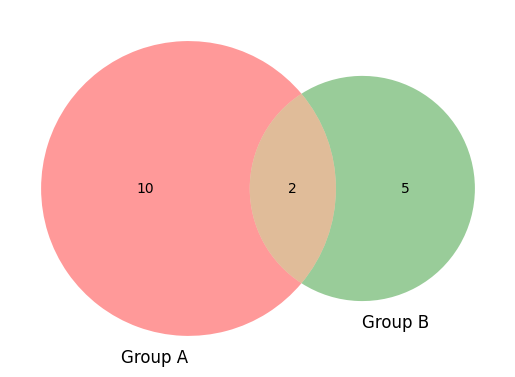

In [2]:
# Use the venn2 function
venn2(subsets=(10, 5, 2), set_labels=("Group A", "Group B"))
plt.show()

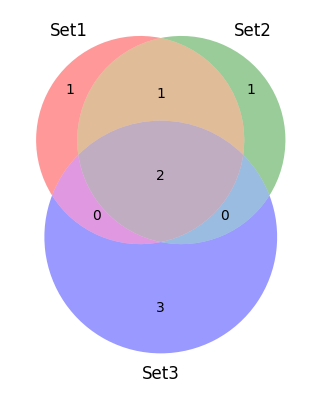

In [3]:
set1 = set(["A", "B", "C", "D"])
set2 = set(["B", "C", "D", "E"])
set3 = set(["C", "D", " E", "F", "G"])

venn3([set1, set2, set3], ("Set1", "Set2", "Set3"))
plt.show()

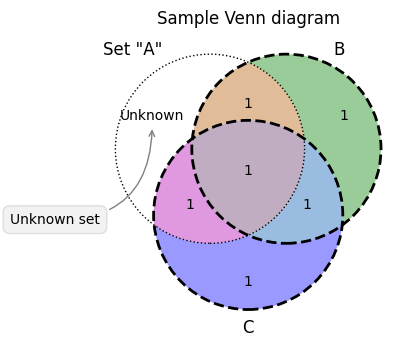

In [4]:
plt.figure(figsize=(4, 4))
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=("A", "B", "C"))
v.get_patch_by_id("100").set_alpha(1.0)
v.get_patch_by_id("100").set_color("white")
v.get_label_by_id("100").set_text("Unknown")
v.get_label_by_id("A").set_text('Set "A"')
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle="dashed")
c[0].set_lw(1.0)
c[0].set_ls("dotted")
plt.title("Sample Venn diagram")
plt.annotate(
    "Unknown set",
    xy=v.get_label_by_id("100").get_position() - np.array([0, 0.05]),
    xytext=(-70, -70),
    ha="center",
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", fc="gray", alpha=0.1),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.5", color="gray"),
)
plt.show()

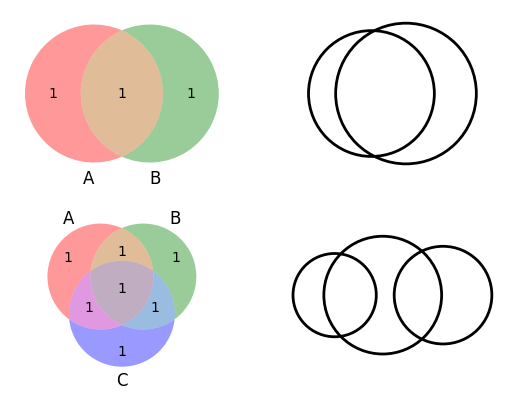

In [5]:
figure, axes = plt.subplots(2, 2)
venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("A", "B"), ax=axes[0][0])
venn2_circles((1, 2, 3), ax=axes[0][1])
venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels=("A", "B", "C"), ax=axes[1][0])
venn3_circles({"001": 10, "100": 20, "010": 21, "110": 13, "011": 14}, ax=axes[1][1])
plt.show()